In [1]:
import geopandas as gp
from shapely import wkt
from shapely.geometry import Point, Polygon
from shapely.ops import unary_union
import pandas as pd
import numpy as np
from pprint import pprint
import os
import glob
import openpyxl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import plotly.express as px #if using plotly
import folium
import warnings

In [2]:
pd.set_option('display.max_columns', None)  # display all columns
pd.options.display.float_format = '{:20,.2f}'.format  # suppress scientific notation

## Research Questions

### 1) Is there a significant difference in the proportion of minorities within a given flaring buffer zone versus outside the buffer? 

#### Ultimate goal is a comparison of six different buffers (of 100; 400; 800; 1,000; 1,600; and 2,000 m) following Czolowski et al, 2017

Null: Proportion of BG in a buffer is independent of minority status.
Alt:  Proportion of BG in a buffer is related to minority status.
  
Test stat: Difference in weighted minority proportions.

Weighted minority proportion = sumproduct(minority_prop * intersect_prop) / sum(intersect_prop)
minority_prop is the proportion of minorities in a block group
intersect_prop is the proportion of BG area residing in the buffer zone

Permutation testing: Permute the intersect_prop variable, holding the fraction of minorities in each BG constant.
 
Process   
a) Calculate the actual minority proportions of the aggregrate in-buffer and out-buffer areas
Using 2km buffer for starters (Czolowski, 2017)  
b) Scramble the intersect_prop variable, holding the minority_prop variable constant.   
c) Calculate number of simulated proportions that match or exceed the actual proportion. Calculate p-value.  


## Load data, set project CRS

In [3]:
ca_state = gp.read_file("data/CA_State_TIGER2016.shp")  # CA state
ca_counties = gp.read_file("data/CA_Counties_TIGER2016.shp")  # CA counties
ca_bg = gp.read_file("data/ca_bg_clean.shp")  # CA block groups, cleaned

In [4]:
# just CA flares
ca_flares = gp.read_file("data/ca_flares_clean.shp")
print(f'Flares found: {len(ca_flares)}')

# CA block groups merged with EJscreen data
ca_bg_joined = gp.read_file("data/ca_bg_joined_clean.shp")

# update col name for correct area b/c it gets saved as a truncated version when saved as a shapefile out of the 
# main data cleaning notebook
ca_bg_joined.rename(columns={'shape_ar_1':'shape_area_new'}, inplace=True)  # old:new.
print(f'BGs found: {len(ca_bg_joined)}')

Flares found: 117
BGs found: 25607


In [5]:
# set common crs for project
# epsg3310: https://epsg.io/3310-1739
# units: meters
meters_crs = 3310  # Projected crs. this should be good for this overlay() calculation and all of project. 

ca_state = ca_state.to_crs(meters_crs)
ca_counties = ca_counties.to_crs(meters_crs)
ca_bg = ca_bg.to_crs(meters_crs)

#### Discuss w RMI: dropping the three aquatic buffers

In [6]:
# There are three BGs that seem to just be aquatic buffers around the actual county land.
# Dropping them for now 
# IDs: 60839900000, 61119901000, 60379902000
# Explore if needed: ca_bg_joined.explore()

ids_to_drop = [60839900000, 61119901000, 60379902000]

# Drop the rows with those IDs
ca_bg_joined = ca_bg_joined[~ca_bg_joined['ID'].isin(ids_to_drop)]

## Analysis
### Functions

In [7]:
def create_buffer_intersection(flares_df, social_df, buffer_size):
    social_df = social_df[['ID', 'CNTY_NAME', 'Shape_Area', 'ACSTOTPOP', 'MINORPOP', 'D_PM25_2', 'shape_area_new', 'geometry']]
    
    #flares_df = set_geometry_buffer(flares_df, buffer_size)
    buffer_col = f"buffer_{buffer_size}m"
    flares_df[buffer_col] = flares_df['geometry'].buffer(distance=buffer_size)

    flares_df = flares_df.set_geometry(buffer_col)
    
    temp = flares_df.unary_union
    all_buffers = gp.GeoDataFrame({'geometry': [temp]}, crs=flares_df.crs)  # convert back to geodf for processing
    
    bg_inbuffer = gp.overlay(social_df, all_buffers, how='intersection')  # could look at keep_geom=False
    
    return bg_inbuffer

In [71]:
buffer_size=2000
test_intersection = create_buffer_intersection(ca_flares, ca_bg_joined, buffer_size)

In [72]:
df_final = calc_intersect_stats(test_intersection, ca_bg_joined, ca_bg, buffer_size)

In [83]:
(df_final['intersect_prop'] != 0).sum()

238

In [84]:
df_non_zero = df_final[df_final['intersect_prop'] != 0]

In [85]:
df_non_zero.sample(2)

,ID,CNTY_NAME,ACSTOTPOP,MINORPOP,D_PM25_2,shape_area_new,intersect_area,intersect_prop,bg_geom,intersect_geom,ACSTOTPOP_intersect_count,MINORPOP_intersect_count,ACSTOTPOP_bg_totprop,MINORPOP_bg_totprop
21705,60375754012,Los Angeles County,1764,1679,70.85,"88,265.00","2,240.99",0.03,"POLYGON ((166911.199 -468333.383, 166912.494 -...","POLYGON ((166965.679 -468442.117, 166912.357 -...",44.79,42.63,1.00,0.95
1055,60375780003,Los Angeles County,1111,1036,50.58,"202,895.90",6.14,0.00,"POLYGON ((165285.750 -467414.803, 165284.012 -...","POLYGON ((165300.399 -467515.481, 165286.816 -...",0.03,0.03,1.00,0.93


In [86]:
df_non_zero.to_csv("data/testing_calc.csv")


In [8]:
def calc_intersect_stats(bg_inbuffer, social_df, ca_blockgroups, buffer_size):
    
    # Create new 'area' column for the areas of the intersections
    bg_inbuffer['intersect_area'] = bg_inbuffer.area
    
    # Calculate the proportion of each block group within the buffer zone
    bg_inbuffer['intersect_prop'] = bg_inbuffer['intersect_area'] / bg_inbuffer['shape_area_new']
    
    # Rename geometry col to intersect_geom so it's clear these geoms are just the intersections
    bg_inbuffer.rename(columns={'geometry':'intersect_geom'}, inplace=True)  # old:new. Match col names for merging

    # merge with ca_bg block groups to get full BG polygon geoms back in the df
    bg_inbuffer = pd.merge(bg_inbuffer, ca_blockgroups, on='ID')

    # Rename geometry column for clarity
    bg_inbuffer.rename(columns={'geometry':'bg_geom'}, inplace=True)  # old:new. Match col names for merging
    
    bg_inbuffer = bg_inbuffer.set_geometry('bg_geom')  # set to the buffers rather than the points

    # merge the intersected data back into the full df of all block groups
    df_final = gp.sjoin(social_df, bg_inbuffer, how = "left", predicate = 'contains')
    
    # Filter cols to just what's needed
    df_final = df_final[['ID_left', 'CNTY_NAME_left', 'ACSTOTPOP_left', 'MINORPOP_left', 'D_PM25_2_left', 'shape_area_new_left', 'intersect_area', 'intersect_prop', 'geometry', 'intersect_geom']]

    # clean things up after the sjoin
    new_cols = [col.replace('_left', '') if col.endswith('_left') else col for col in df_final.columns]
    df_final.columns = new_cols
    
    # Rename geometry column for clarity
    df_final.rename(columns={'geometry':'bg_geom'}, inplace=True)  # old:new. Match col names for merging

    # Replace NAs in both the intersect_prop and intersect_area with 0 for BG that have no intersection
    no_intersect = df_final['intersect_prop'].isna() | df_final['intersect_area'].isna()

    # Update the values in the 'intersect_prop' and 'intersect_area' columns of those rows to 0 using the loc method
    df_final.loc[no_intersect, ['intersect_prop', 'intersect_area']] = 0
    
    # Apply the proportion to each demographic variable to find counts by variable
    demo_vars = ['ACSTOTPOP', 'MINORPOP']
    for var in demo_vars:
        df_final[var + '_intersect_count'] = df_final[var] * df_final['intersect_prop']

    # find overall proportions for each demo var by dividing var count by respective total population    
    for var in demo_vars:
        df_final[var + '_bg_totprop'] = df_final[var] / df_final['ACSTOTPOP']
    
    # Finally, save a subsetted version of the df for permutation testing
    df_forpermutation = df_final[['MINORPOP_bg_totprop', 'intersect_prop']]
    df_forpermutation.to_csv(F"data/df_{buffer_size}m_forpermutation.csv", index=False)
    
    return df_final

#### create a spreadsheet of df_final to check the calcs

In [58]:
def calc_proportions(df, buffer_size, gen_table):
    
    df.to_csv("data/testing_calc.csv")
    
    in_buffer = np.sum(df['MINORPOP_bg_totprop'] * df['intersect_prop']) / np.sum(df['intersect_prop'])
    out_buffer = (np.sum(df['MINORPOP_bg_totprop'] * (1 - df['intersect_prop'])) /
                  np.sum(1 - df['intersect_prop']))
    
    # table that compares the in-buffer proportions to the outside-buffer proportions
    temp = pd.DataFrame({'ID': [f"buffer_{buffer_size}"], 'Buffer': [buffer_size], 
                         'in_buffer': [in_buffer], 'out_buffer': [out_buffer]})
    
    
    gen_table = pd.concat([gen_table, temp], ignore_index=True)
    
    return gen_table
    

In [59]:
def calc_counts(df, buffer_size, gen_table):

    in_buffer = df['MINORPOP_intersect_count'].sum()
    out_buffer = df['ACSTOTPOP'].sum() - in_buffer

    # table that compares the in-buffer proportions to the outside-buffer proportions
    temp = pd.DataFrame({'ID': [f"buffer_{buffer_size}"], 'Buffer': [buffer_size], 'in_buffer': [in_buffer], 'out_buffer': [out_buffer]})
    
    gen_table = pd.concat([gen_table, temp], ignore_index=True)
    
    return gen_table

In [60]:
def combined_calcs(flares_df, social_df, ca_blockgroups, buffer_size, gen_table):
    
    intersect = create_buffer_intersection(flares_df, social_df, buffer_size)
    df = calc_intersect_stats(intersect, social_df, ca_blockgroups, buffer_size)
    
    gen_table = calc_proportions(df, buffer_size, gen_table)

    return gen_table

In [67]:
def all_buffer_calcs(gen_table, buffer_sizes = [100, 400, 800, 1000, 1600, 2000]):

    for buffer_size in buffer_sizes:
        gen_table = combined_calcs(ca_flares, ca_bg_joined, ca_bg, buffer_size, gen_table.copy())  
        
    return gen_table

#### *Figure out why "buffer_size" is being treated literally.*

### Proportions table

In [68]:
# initialize empty df
prop_table = pd.DataFrame(columns=['ID', "Buffer", 'in_buffer', 'out_buffer'])
name = prop_table.name = 'Proportions Table'

In [69]:
prop_table = all_buffer_calcs(prop_table, buffer_sizes=[100, 400])
prop_table['Buffer'] = prop_table['Buffer'].astype(float)

In [70]:
prop_table

,ID,Buffer,in_buffer,out_buffer
0,buffer_100,100.00,0.39,0.60
1,buffer_400,400.00,0.44,0.60


#### *The out-buffer proportions are not being calculated correctly. Code seems right, though. Troubleshoot with JC*

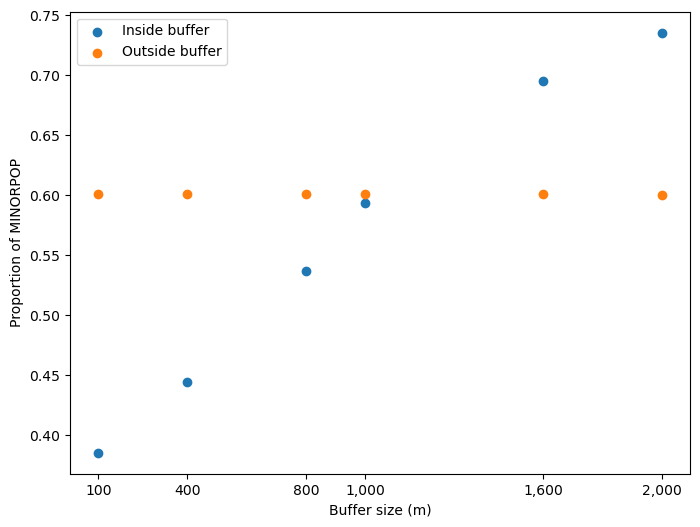

In [16]:
# scatterplot of buffer props

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(prop_table['Buffer'], prop_table['in_buffer'], label='Inside buffer')
ax.scatter(prop_table['Buffer'], prop_table['out_buffer'], label='Outside buffer')

# Set xticks to the buffer sizes
xticks = [100, 400, 800, 1000, 1600, 2000]
ax.set_xticks(xticks)

# Set xticklabels to the buffer sizes
xticklabels = [f"{b:,}" for b in xticks]
ax.set_xticklabels(xticklabels)
ax.set_xlabel('Buffer size (m)')
ax.set_ylabel('Proportion of MINORPOP')
ax.legend()
plt.show()


### Counts table

In [17]:
# initialize empty df
count_table = pd.DataFrame(columns=['ID', "Buffer", 'in_buffer', 'out_buffer'])
name = count_table.name = 'Counts Table'

In [18]:
# def combined_calcs(flares_df, social_df, ca_blockgroups, buffer_size, gen_table):
    
#     intersect = create_buffer_intersection(flares_df, social_df, buffer_size)
#     df = calc_intersect_stats(intersect, social_df, ca_blockgroups, buffer_size)
    
#     #gen_table = calc_proportions(df, buffer_size, gen_table)
#     gen_table = calc_counts(df, buffer_size, gen_table)

#     return gen_table

In [19]:
count_table = all_buf_calcs(count_table)
count_table['Buffer'] = count_table['Buffer'].astype(float)

In [20]:
count_table

,ID,Buffer,in_buffer,out_buffer
0,buffer_100,100.00,81.15,"39,345,941.85"
1,buffer_400,400.00,"1,671.84","39,344,351.16"
2,buffer_800,800.00,"8,008.53","39,338,014.47"
3,buffer_1000,"1,000.00","15,660.90","39,330,362.10"
4,buffer_1600,"1,600.00","65,654.03","39,280,368.97"
5,buffer_2000,"2,000.00","127,549.70","39,218,473.30"


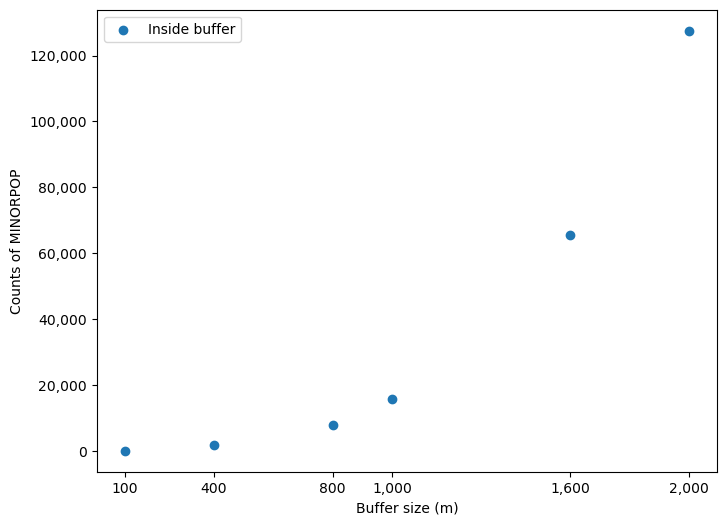

In [21]:
# scatterplot of buffer counts
# visualizing just in-buffer counts for readability. 

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(count_table['Buffer'], count_table['in_buffer'], label='Inside buffer')
#ax.scatter(count_table['Buffer'], count_table['out_buffer'], label='Outside buffer')

# Define the formatter function
def thousand_fmt(x, pos):
    return f"{x:,.0f}"
# Set the formatter function for the y-axis
ax.yaxis.set_major_formatter(mtick.FuncFormatter(thousand_fmt))

# Set xticks to the buffer sizes
xticks = [100, 400, 800, 1000, 1600, 2000]
ax.set_xticks(xticks)

# Set xticklabels to the buffer sizes
xticklabels = [f"{b:,}" for b in xticks]
ax.set_xticklabels(xticklabels)
ax.set_xlabel('Buffer size (m)')
ax.set_ylabel('Counts of MINORPOP')
ax.legend()
plt.show()

## Visualization with Folium

In [22]:
# Convert the GeoDataFrame to the same CRS as the folium map (if necessary)

# Create a folium map with a center location
m = folium.Map(location=[38.377158,-121.645792], zoom_start=6, tiles=None,overlay=False)  #start w lat/long roughly in center of CA
base_map = folium.FeatureGroup(name='Base map', overlay=True, control=False)
folium.TileLayer(tiles='OpenStreetMap').add_to(base_map)
base_map.add_to(m)

In [23]:
# # Choropleth of Block Groups

# folium.Choropleth(ca_bg_joined,
#                   data=ca_bg_joined,
#                   columns = ['ID', 'D_PM25_2'], 
#                   key_on='feature.properties.ID',
#                   fill_color="Reds",
#                   fill_opacity=0.7,
#                   line_opacity=0.2,
#                   legend_name="PM2.5 Index",
#                  name="Block Groups").add_to(m)


In [24]:
# # Feature Group: All Block Groups

# def style_function3(feature):
#     return {
#         'fillColor': 'grey',
#         'color': 'grey',
#         'fillOpacity': 0.05
#     }

# all_bg = folium.FeatureGroup(name='All BG', overlay=True)
# folium.GeoJson(
#     data=ca_bg["geometry"],
#     style_function=style_function3
# ).add_to(all_bg)
# all_bg.add_to(m)

In [25]:
# # Feature Group: Buffers

# def style_function1(feature):
#     return {
#         'fillColor': 'red',
#         'color': 'red',
#         'fillOpacity': 0.2
#     }

# all_flares_buffers = folium.FeatureGroup(name='Flare Buffers', overlay=True)
# folium.GeoJson(
#     data=ca_flares["buffer_2000m"],
#     style_function=style_function1
# ).add_to(all_flares_buffers)
# all_flares_buffers.add_to(m)

In [26]:
# # Feature Group: BG-Buffer Intersections

# def style_function2(feature):
#     return {
#         'fillColor': 'blue',
#         'color': 'blue',
#         'fillOpacity': 0.1
#     }

# intersect = folium.FeatureGroup(name='BG-Flare Intersections', overlay=True)
# folium.GeoJson(
#     data=test['intersect_geom'],
#     style_function=style_function2
# ).add_to(intersect)
# intersect.add_to(m)

NameError: name 'test' is not defined

In [ ]:
# # Add hover functionality
# test = test.to_crs("EPSG:3857")
# test = test.set_geometry('bg_geom')
# test_json = test.__geo_interface__

In [ ]:

# style_function = lambda x: {'fillColor': '#ffffff', 
#                             'color':'#000000', 
#                             'fillOpacity': 0.1, 
#                             'weight': 0.1}
# highlight_function = lambda x: {'fillColor': '#999999', 
#                                 'color':'#999999', 
#                                 'fillOpacity': 0.50, 
#                                 'weight': 0.1}
# NIL = folium.features.GeoJson(
#     data = map_test,
#     style_function=style_function, 
#     control=False,
#     highlight_function=highlight_function, 
#     tooltip=folium.features.GeoJsonTooltip(
#         fields=['ID','CNTY_NAME'],# 'D_PM25_2', 'ACSTOTPOP', 'MINORPOP','shape_area_new', 'intersect_prop', 'intersect_area', 'MINORPOP_bg_totprop'],
#         style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
#     )
# )

In [ ]:
# # add hover functionality as child to map, add layering, display map
# m.add_child(NIL)
# m.keep_in_front(NIL)
# folium.LayerControl().add_to(m)
# m

In [ ]:
# # Flares
# all_flares_points = folium.FeatureGroup(name='flare points', overlay=True)
# folium.GeoJson(data=ca_flares["geometry"]).add_to(all_flares_points)
# all_flares_points.add_to(m)